# Feeder routes API 

This notebook calls Transmilenio API to geographic information of zonal routes (which include feeder routes). 
The proces is done in two steps. 
- Read Geojson API, which returns routes attributes 
- MapService API: Iterate over routes objectID to request polyline. 

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import time

In [4]:
#GeoJson API. Note that this api does not extract geographic information 
zonal_routes = gpd.read_file('https://opendata.arcgis.com/datasets/4431bc73a14243d88b066e37f8da5e20_1.geojson')

In [5]:
%%time
#Shapefiles are here (Actually, this is a polyline in crs: 'EPSG:3116')
att_list = []
path_list = []
for id_line in zonal_routes.objectid:
    url = f'''https://gis.transmilenio.gov.co/arcgis/rest/services/Zonal/consulta_rutas_zonales/MapServer/1/{id_line}?f=pjson'''
    r = requests.get(url).json()
    try: 
        att_list.append(r['feature']['attributes'])
        path_list.append(r['feature']['geometry']['paths'])
    except KeyError:
        pass
    
#Note: Since we already extract attribute, there is no need to do it here as well. But i'll keep it for future reference. 

CPU times: user 11.7 s, sys: 877 ms, total: 12.5 s
Wall time: 6min 37s


In [12]:
#Building routes linestrings 
shape_list = []
for route in path_list:
    shape = LineString(route[0])
    shape_list.append(shape)

# Inserting shapes to general geopandas dataframe
zonal_routes['geometry'] = shape_list
zonal_routes = zonal_routes.to_crs('EPSG:3116')

#Filtering feeder routes 
feeder_routes = zonal_routes[zonal_routes.tipo_ruta_zonal == 4]

## Results

In [13]:
feeder_routes.head()

,objectid,route_id_ruta_zonal,route_name_ruta_zonal,codigo_definitivo_ruta_zonal,denominacion_ruta_zonal,origen_ruta_zonal,destino_ruta_zonal,tipo_ruta_zonal,longitud_ruta_zonal,tipo_servicio_ruta_zonal,delega_ruta_zonal,zona_origen_ruta_zonal,zona_destino_ruta_zonal,localidad_origen_ruta_zonal,localidad_destino_ruta_zonal,fecha_implementacion_ruta_zonal,globalid,operador_ruta_zonal,geometry
0,2,2422,2-8a,2-8,EXPRESO ORIENTAL 170,PORTAL NORTE,EXPRESO ORIENTAL 170,4,8.820693,1,2.0,1,1,1,1,-,{B7F8F499-CE7F-4AE1-92E7-6B1CFA5F0DCA},CONSORCIO EXPRESS N,"LINESTRING (1003467.171 1017417.527, 1003447.6..."
9,12,858,3-7a,3-7,AV CARACAS,PORTAL USME,AV CARACAS,4,6.141805,4,2.0,12,12,5,5,-,{1DA3F6F6-FD99-4FFD-8C18-1D17CAF2D85C},TRANZIT US,"LINESTRING (995372.049 992850.453, 995378.149 ..."
20,25,1684,1-10a,1-10,BOLIVIA BOCHICA II,PORTAL 80,BOLIVIA BOCHICA II,4,4.067666,1,2.0,4,4,10,10,-,{FD5F8758-825D-45C1-A6C2-4B9B2185DAB5},ESTE ES MI BUS CO,"LINESTRING (996358.739 1012563.324, 996339.102..."
22,28,2293,16-13a,16-13,AV. C. CALI - HAYUELOS,PORTAL EL DORADO,AV. C. CALI - HAYUELOS,4,10.686812,1,1.0,6,6,9,9,-,{354C10B6-2E29-431E-8743-4E8EBF1374B0},CONSORCIO EXPRESS D,"LINESTRING (993213.458 1006682.135, 993278.926..."
29,37,899,9-9a,9-9,BOSA SANTA FE,PORTAL AMERICAS,BOSA SANTA FE,4,9.319468,1,2.0,9,9,8,7,-,{440A73EF-A9CD-499D-A3AF-9676B80B0EEC},MASIVO CAPITAL KE,"LINESTRING (989396.323 1003660.693, 989323.752..."


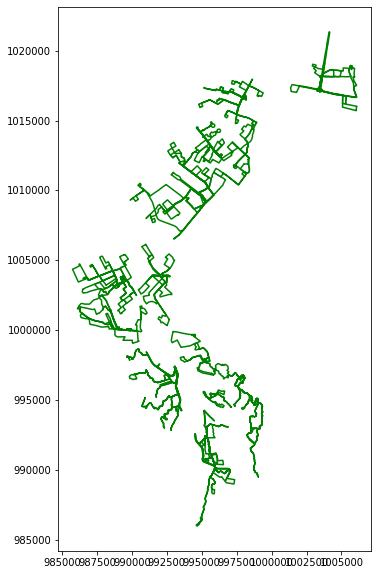

In [14]:
feeder_routes.plot(figsize = (10,10), color = 'g')

## Saving to disk

In [15]:
#Saving File
input_path = "../../data/input/"
save_path = input_path + 'feeder_routes/feeder_routes.shp''
feeder_routes.to_file(save_path)